## Explainability Map Maker

1. Recall test results from data/*.pkl
2. Make stats (find best mae indices)
3. Draw

In [61]:
import os
from pathlib import Path
import pickle
import numpy as np
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme();

from sage.visualization.vistool import plot_vismap
from utils.analysis import (
    Result, FileSelector,
    group_stats, cherry_picker, check_existence, save2nifti
)

In [2]:
AVG = np.load("./data/average.npy")

with open("./data/naive_test_results.pkl", "rb") as f:
    naive_results = pickle.load(f)
    naive_results = {e[0]: e[1] for e in sorted(naive_results.items(), key=lambda x: x[0])}
    
with open("./data/augment_test_results.pkl", "rb") as f:
    augment_results = pickle.load(f)
    augment_results = {e[0]: e[1] for e in sorted(augment_results.items(), key=lambda x: x[0])}


In [3]:
naive = Result(naive_results)
augment = Result(augment_results)

In [4]:
last_values_naive = [e[-1][1] for e in naive.raw_data.values()]
last_values_augment = [e[-1][1] for e in augment.raw_data.values()]

best_values_naive = [min(_[1] for _ in e) for e in naive.raw_data.values()]
best_values_augment = [min(_[1] for _ in e) for e in augment.raw_data.values()]

earlystopped_values_naive = [e[-20][1] for e in naive.raw_data.values()]
earlystopped_values_augment = [e[-20][1] for e in augment.raw_data.values()]

total_train_naive = [len(e) for e in naive.raw_data.values()]
total_train_augment = [len(e) for e in augment.raw_data.values()]

best_indices_naive = [sorted(e, key=lambda x: x[1])[0][0] for e in naive.raw_data.values()]
best_indices_augment = [sorted(e, key=lambda x: x[1])[0][0] for e in augment.raw_data.values()]

In [5]:
group_stats(last_values_naive, last_values_augment, "Last Value")
group_stats(best_values_naive, best_values_augment, "Best Value")
group_stats(earlystopped_values_naive, earlystopped_values_augment, "Early Stopped Value")
group_stats(total_train_naive, total_train_augment, "Total Training Epoch Value")
group_stats(best_indices_naive, best_indices_augment, "Best Indices Value")

Last Value
Naive  : 6.446 ± 0.468
Augment: 5.960 ± 0.374
Statistics: 8.11 p-value: 4.9000133813633764e-14

Best Value
Naive  : 5.935 ± 0.354
Augment: 5.657 ± 0.336
Statistics: 5.71 p-value: 4.11114005412092e-08

Early Stopped Value
Naive  : 6.523 ± 0.535
Augment: 6.108 ± 0.474
Statistics: 5.80 p-value: 2.4986330555688152e-08

Total Training Epoch Value
Naive  : 55.814 ± 19.766
Augment: 68.550 ± 21.861
Statistics: -4.32 p-value: 2.4214394200238917e-05

Best Indices Value
Naive  : 42.696 ± 16.384
Augment: 58.000 ± 18.856
Statistics: -6.13 p-value: 4.59235797283032e-09



### Make maps based on their best MAE

In [6]:
naive_fileselector = FileSelector("naive")
best_maps_naive = np.array(list(map(
    partial(cherry_picker, selector=naive_fileselector), 
    list(filter(\
        partial(check_existence, selector=naive_fileselector), \
        zip(range(len(best_indices_naive)), best_indices_naive))
))))

42 46
101 88


In [7]:
augment_fileselector = FileSelector("augment")
best_maps_augment = np.array(list(map(
    partial(cherry_picker, selector=augment_fileselector), 
    list(filter(\
        partial(check_existence, selector=augment_fileselector), \
        zip(range(len(best_indices_augment)), best_indices_augment))
))))

### Pick top 1% value from each checkpoints

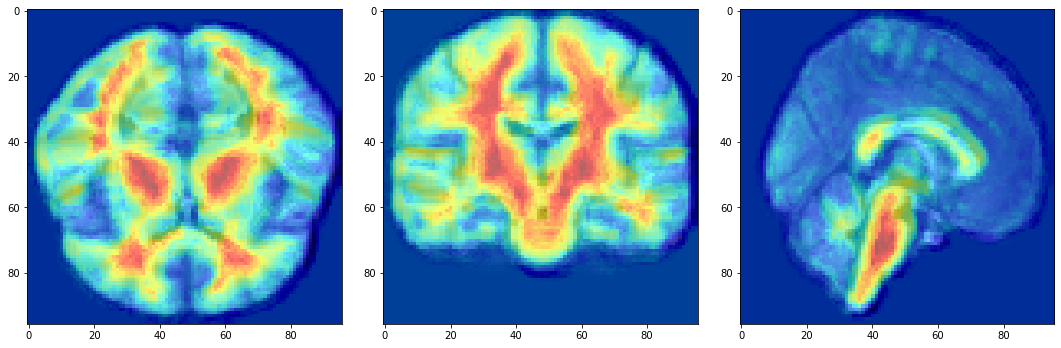

In [28]:
best_maps_naive_copy = best_maps_naive.copy()
for idx, npy in enumerate(best_maps_naive):
    thresholded = (np.abs(npy) > np.quantile(np.abs(npy), 0.9)) * npy
    best_maps_naive_copy[idx] = thresholded

plot_vismap(AVG, np.mean(best_maps_naive_copy, axis=0), masked=False);

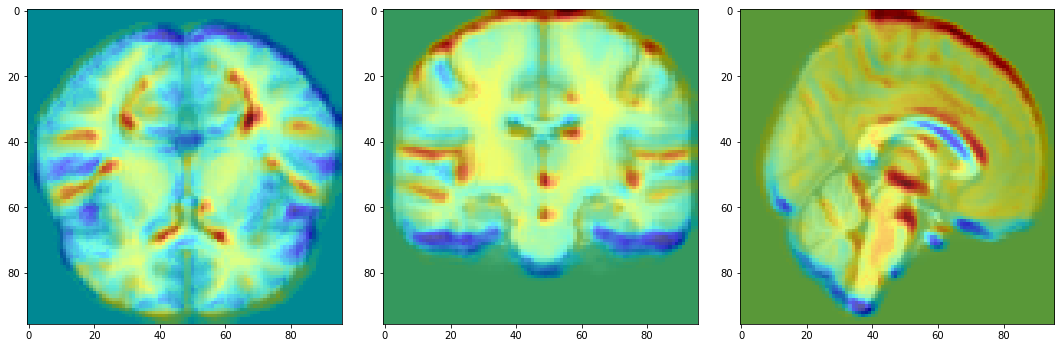

In [29]:
best_maps_augment_copy = best_maps_augment.copy()
for idx, npy in enumerate(best_maps_augment):
    thresholded = (np.abs(npy) > np.quantile(np.abs(npy), 0.9)) * npy
    best_maps_augment_copy[idx] = thresholded

plot_vismap(AVG, np.mean(best_maps_augment_copy, axis=0), masked=False);

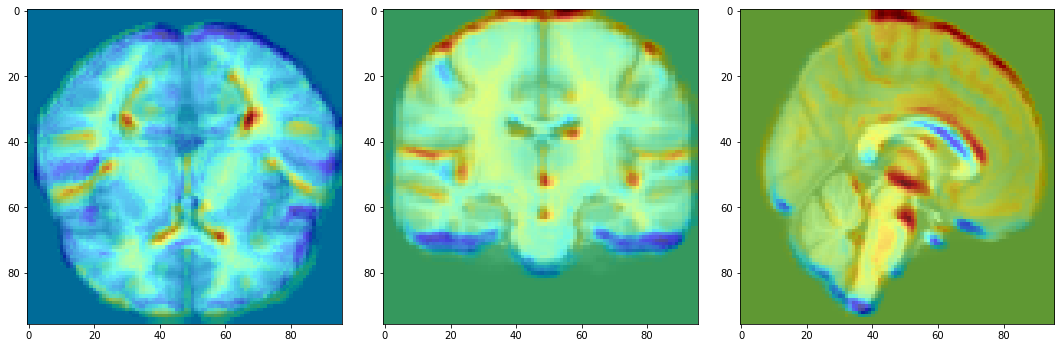

In [36]:
best_maps_augment_top = np.array([
    (np.abs(npy) > np.quantile(np.abs(npy), quantile)) for npy in best_maps_augment
]) * best_maps_augment
plot_vismap(AVG, np.mean(best_maps_augment_top, axis=0), masked=False);

In [30]:
save2nifti(best_maps_naive_copy, "../miccai2022/naive_raw_top10.nii")
save2nifti(best_maps_augment_copy, "../miccai2022/aug_raw_top10.nii")

Came across with array dimension of 4, (100, 96, 96, 96).
Shrink with average on axis=0
Successfully saved.
Came across with array dimension of 4, (100, 96, 96, 96).
Shrink with average on axis=0
Successfully saved.


### Top n% with m-agreements between seeds

In [155]:
quantile = .9
top = int(1-quantile)

agree_threshold = 50

In [145]:
def count_nonzero_voxels(thrsh):
    return (thrsh != 0).sum()
    
def exp_quantile_agree(maps_agg, quantile, agree_threshold, plot=True):

    print(f"Quantile: {quantile:.2f} | Agree Threhsold: {agree_threshold}")

    bool_brain = np.array([
        (np.abs(npy) > np.quantile(np.abs(npy), quantile)) for npy in maps_agg
    ])
    agreement = bool_brain.sum(axis=0) > agree_threshold
    thresholded = (maps_agg * agreement).sum(axis=0)
    print(f"Nonzero Voxels: {count_nonzero_voxels(thresholded)}")
    if plot:
        plot_vismap(AVG, thresholded, masked=False);
    return thresholded

In [146]:
# naive_nonzero = []
# aug_nonzero = []
# intersection_nonzero = []

# for _agree_threshold in range(100):
    
#     naive_tmp = exp_quantile_agree(best_maps_naive, quantile, _agree_threshold, plot=False)
#     aug_tmp = exp_quantile_agree(best_maps_augment, quantile, _agree_threshold, plot=False)
#     naive_nonzero.append(count_nonzero_voxels(naive_tmp))
#     aug_nonzero.append(count_nonzero_voxels(aug_tmp))

#     intersection = ((naive_tmp != 0) & (aug_tmp != 0)).astype(np.float32)
#     intersection_nonzero.append(count_nonzero_voxels(intersection))

In [147]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(14, 8))
# ax.set_title(f"Non zero Voxels for top{round(100 * (1-quantile))}%", size="x-large")
# ax.plot(naive_nonzero, label="Naive")
# ax.plot(aug_nonzero, label="Augmentation")
# ax.plot(intersection_nonzero, label="Intersection")
# # ax.set_xlim(30, 60)
# # ax.set_ylim(0, 1000)
# ax.legend()

Naive
Quantile: 0.90 | Agree Threhsold: 45
Nonzero Voxels: 7807


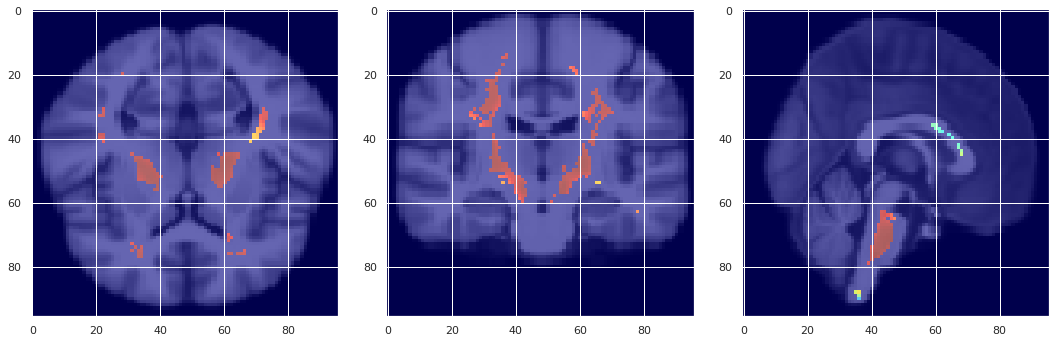

Augment
Quantile: 0.90 | Agree Threhsold: 45
Nonzero Voxels: 7532


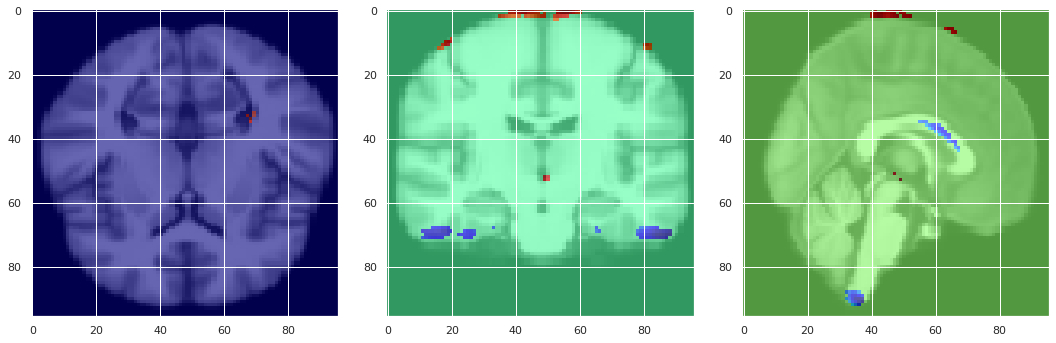

In [148]:
print("Naive")
naive_tmp = exp_quantile_agree(best_maps_naive, quantile, agree_threshold);
print("Augment")
aug_tmp = exp_quantile_agree(best_maps_augment, quantile, agree_threshold);

Nonzero Voxels: 118


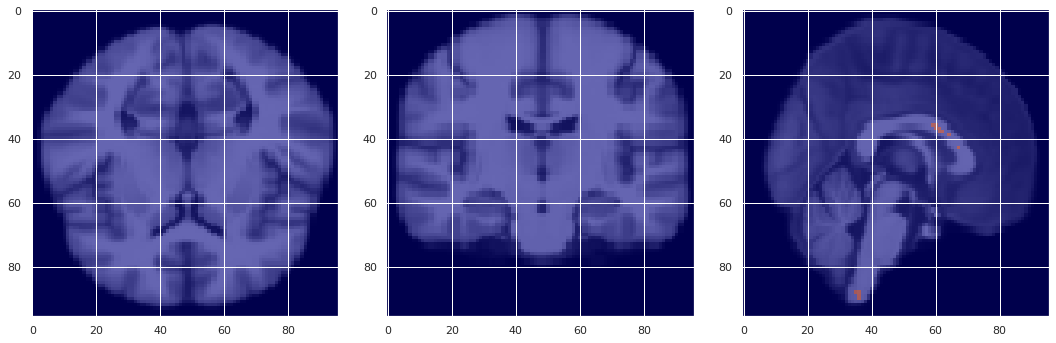

In [149]:
intersection = ((naive_tmp != 0) & (aug_tmp != 0)).astype(np.float32)
print(f"Nonzero Voxels: {count_nonzero_voxels(intersection)}")
plot_vismap(AVG, intersection, masked=True);

In [150]:
top = round((1 - quantile)*100)
config = f"top{top}_agree{agree_threshold}"
dir_name = f"../miccai2022/{config}_best"
print(dir_name)
os.mkdir(dir_name)
save2nifti(naive_tmp, Path(dir_name, f"{config}_naive.nii"))
save2nifti(aug_tmp, Path(dir_name, f"{config}_augment.nii"))
save2nifti(intersection, Path(dir_name, f"{config}_intersect.nii"))

Successfully saved.
Successfully saved.
Successfully saved.


In [164]:
def saliency_hist(thrsh):

    val = list(filter(lambda x: x !=0, thrsh.flatten()))
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.hist(val, bins=200)

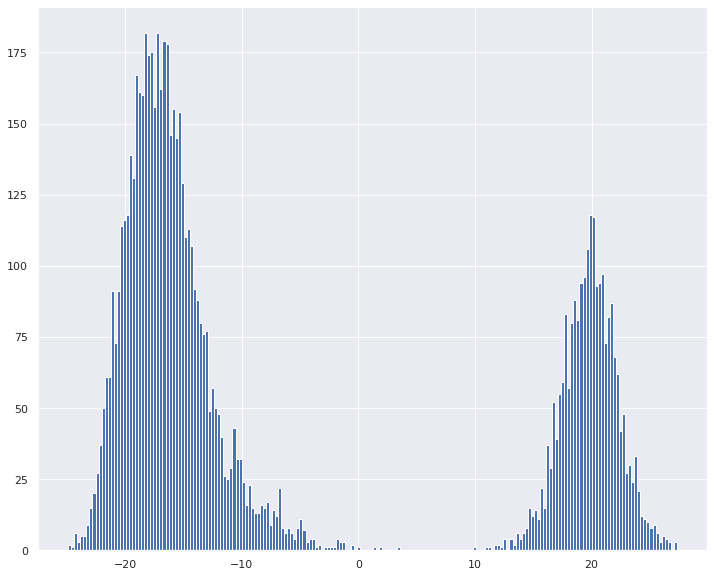

In [ ]:
# saliency_hist(naive_tmp)
saliency_hist(aug_tmp)